In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from plotly.offline import init_notebook_mode,iplot,plot
import plotly.graph_objects as go
init_notebook_mode(connected=True)
import plotly.figure_factory as ff

In [120]:
building = pd.read_csv('/content/drive/MyDrive/building_metadata.csv')
weather = pd.read_csv('/content/drive/MyDrive/weather_train.csv')
train = pd.read_csv('/content/drive/MyDrive/train.csv')

In [121]:
building.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.000,nan
1,0,1,Education,2720,2004.000,nan
2,0,2,Education,5376,1991.000,nan
3,0,3,Education,23685,2002.000,nan
4,0,4,Education,116607,1975.000,nan


In [122]:
train.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.000
1,1,0,2016-01-01 00:00:00,0.000
2,2,0,2016-01-01 00:00:00,0.000
3,3,0,2016-01-01 00:00:00,0.000
4,4,0,2016-01-01 00:00:00,0.000


In [123]:
train.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.000
1,1,0,2016-01-01 00:00:00,0.000
2,2,0,2016-01-01 00:00:00,0.000
3,3,0,2016-01-01 00:00:00,0.000
4,4,0,2016-01-01 00:00:00,0.000


In [124]:
print('Nombre des valeurs manquantes dans train:' ,np.sum(train.isnull().values))
print('Nombre des valeurs manquantes dans weather',np.sum(weather.isnull().values))
print('Nombre des valeurs manquantes dans building:',np.sum(building.isnull().values))

Nombre des valeurs manquantes dans train: 0
Nombre des valeurs manquantes dans weather 136820
Nombre des valeurs manquantes dans building: 1868


In [168]:
print(weather)

        site_id           timestamp  air_temperature  cloud_coverage  \
0             0 2016-01-01 00:00:00           25.000           6.000   
1             0 2016-01-01 01:00:00           24.400             nan   
2             0 2016-01-01 02:00:00           22.800           2.000   
3             0 2016-01-01 03:00:00           21.100           2.000   
4             0 2016-01-01 04:00:00           20.000           2.000   
...         ...                 ...              ...             ...   
139768       15 2016-12-31 19:00:00            3.000             nan   
139769       15 2016-12-31 20:00:00            2.800           2.000   
139770       15 2016-12-31 21:00:00            2.800             nan   
139771       15 2016-12-31 22:00:00            2.200             nan   
139772       15 2016-12-31 23:00:00            1.700             nan   

        dew_temperature  precip_depth_1_hr  sea_level_pressure  \
0                20.000                nan            1019.700   
1  

**On supprime les valeurs manquantes**

In [125]:
# train.dropna()
# weather.dropna()
# building.dropna()

In [126]:
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.        
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [127]:
building = reduce_mem_usage(building)
weather = reduce_mem_usage(weather)
train = reduce_mem_usage(train)

Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.02 MB
Decreased by 65.4%
Memory usage of dataframe is 9.60 MB
Memory usage after optimization is: 4.51 MB
Decreased by 53.0%
Memory usage of dataframe is 616.95 MB
Memory usage after optimization is: 173.90 MB
Decreased by 71.8%


In [128]:

def time_features(df):
    
    # Sort by timestamp
    df.sort_values("timestamp")
    df.reset_index(drop=True)
    
    # Add more features
    df["timestamp"] = pd.to_datetime(df["timestamp"],format="%Y-%m-%d %H:%M:%S")
    df["hour"] = df["timestamp"].dt.hour
    df["dayofweek"] = df["timestamp"].dt.weekday

    df['month'] = df['timestamp'].dt.month

   
    return df
weather  = time_features(weather)
train  = time_features(train)

In [129]:
print(train)

          building_id  meter           timestamp  meter_reading  hour  \
0                   0      0 2016-01-01 00:00:00          0.000     0   
1                   1      0 2016-01-01 00:00:00          0.000     0   
2                   2      0 2016-01-01 00:00:00          0.000     0   
3                   3      0 2016-01-01 00:00:00          0.000     0   
4                   4      0 2016-01-01 00:00:00          0.000     0   
...               ...    ...                 ...            ...   ...   
20216095         1444      0 2016-12-31 23:00:00          8.750    23   
20216096         1445      0 2016-12-31 23:00:00          4.825    23   
20216097         1446      0 2016-12-31 23:00:00          0.000    23   
20216098         1447      0 2016-12-31 23:00:00        159.575    23   
20216099         1448      0 2016-12-31 23:00:00          2.850    23   

          dayofweek  month  
0                 4      1  
1                 4      1  
2                 4      1  
3      

In [130]:
train.shape

(20216100, 7)

In [131]:

print("Percentage of missing values in the train dataset")
train.isna().sum()

Percentage of missing values in the train dataset


building_id      0
meter            0
timestamp        0
meter_reading    0
hour             0
dayofweek        0
month            0
dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0.5, 1.0, 'Distribution of Meter Reading')

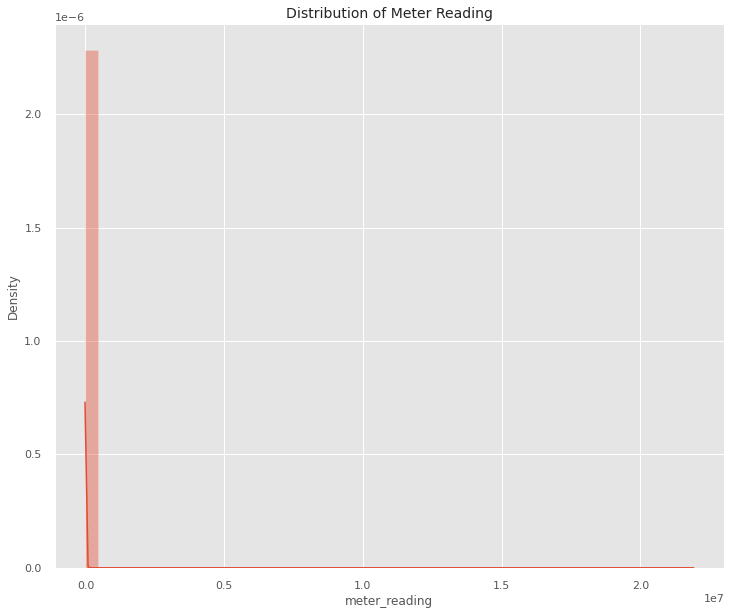

In [132]:
from IPython.core.pylabtools import figsize
import seaborn as sns
figsize(12,10)

# set the histogram, mean and median
sns.distplot(train['meter_reading'],
             kde=True)

# set title, legends and labels
plt.title("Distribution of Meter Reading", size=14)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0.5, 1.0, 'Distribution of Meter Reading')

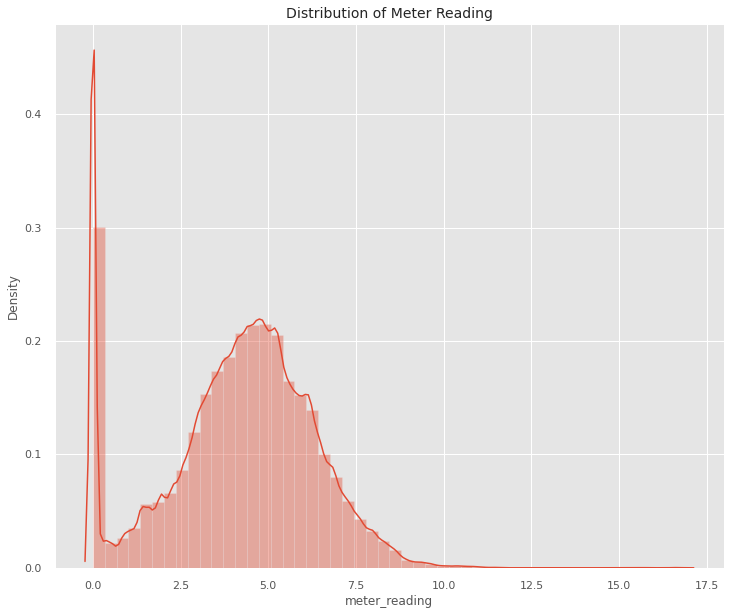

In [133]:

# set the histogram, mean and median
sns.distplot(np.log1p(train['meter_reading']),
             kde=True)

# set title, legends and labels
plt.title("Distribution of Meter Reading", size=14)

Aver des meters différents de 0

In [134]:
positive_train = train[train['meter_reading'] != 0]
positive_train['log_meter_reading'] = np.log(positive_train['meter_reading'])

On essaie d'afficher des meters différents de zéro

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0.5, 1.0, 'Distribution of Logarithm(Meter Reading) w/o 0 Measurements')

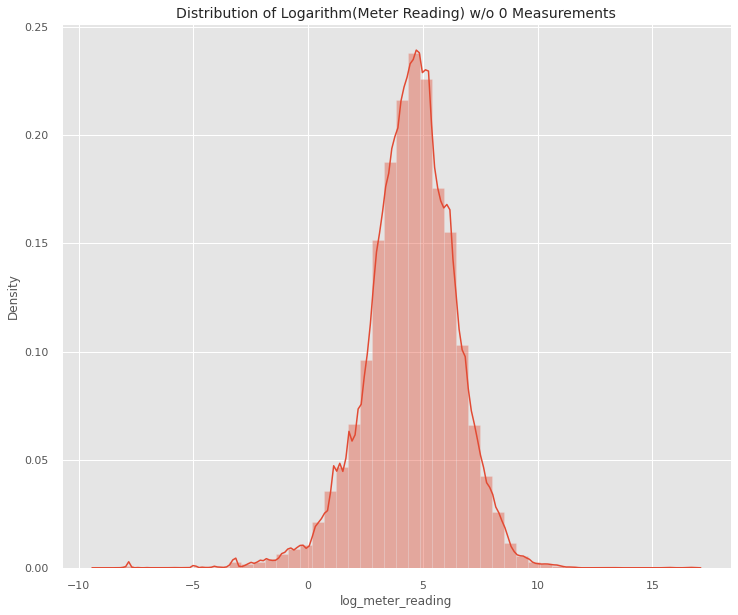

In [135]:
figsize(12,10)

# set the histogram, mean and median
sns.distplot(positive_train['log_meter_reading'], 
             kde=True)


# set title, legends and labels
plt.title("Distribution of Logarithm(Meter Reading) w/o 0 Measurements", size=14)

## **meter reading sur différentes catégories de meter**

In [136]:
# distribution of the meter reading in meters without zeros
figsize(12,10)

#list of different meters
meters = sorted(train['meter'].unique().tolist())
print(meters)

[0, 1, 2, 3]


Text(0.5, 1.0, 'Density of Logartihm(Meter Reading + 1) Among Different Meters')

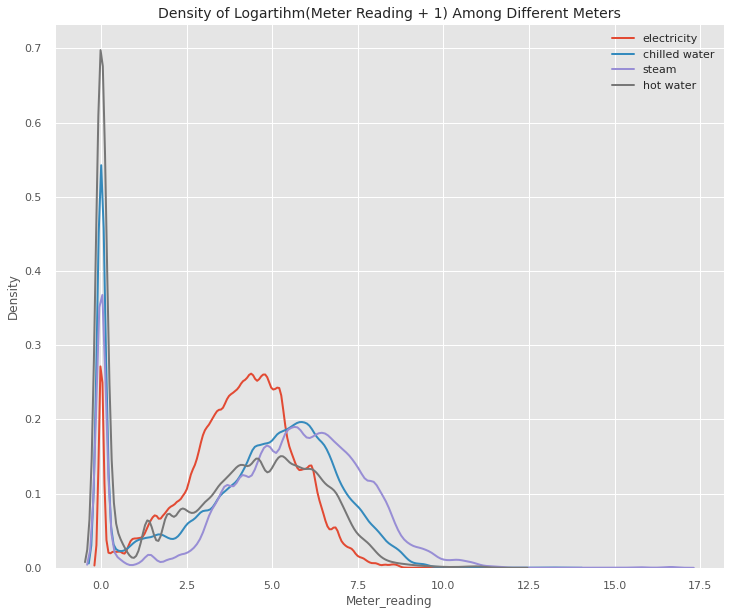

In [137]:
# plot meter_reading distribution for each meter
for meter_type in meters:
    subset = train[train['meter'] == meter_type]
    sns.kdeplot(np.log1p(subset["meter_reading"]), 
                label=meter_type, linewidth=2)

# set title, legends and labels
plt.ylabel("Density")
plt.xlabel("Meter_reading")
plt.legend(['electricity', 'chilled water', 'steam', 'hot water'])
plt.title("Density of Logartihm(Meter Reading + 1) Among Different Meters", size=14)

## **Etude mensuelle et par heures de chaque meter_reading**

### **electricity meter**

In [138]:
train.head()

,building_id,meter,timestamp,meter_reading,hour,dayofweek,month
0,0,0,2016-01-01,0.000,0,4,1
1,1,0,2016-01-01,0.000,0,4,1
2,2,0,2016-01-01,0.000,0,4,1
3,3,0,2016-01-01,0.000,0,4,1
4,4,0,2016-01-01,0.000,0,4,1


In [139]:
print(train)

          building_id  meter           timestamp  meter_reading  hour  \
0                   0      0 2016-01-01 00:00:00          0.000     0   
1                   1      0 2016-01-01 00:00:00          0.000     0   
2                   2      0 2016-01-01 00:00:00          0.000     0   
3                   3      0 2016-01-01 00:00:00          0.000     0   
4                   4      0 2016-01-01 00:00:00          0.000     0   
...               ...    ...                 ...            ...   ...   
20216095         1444      0 2016-12-31 23:00:00          8.750    23   
20216096         1445      0 2016-12-31 23:00:00          4.825    23   
20216097         1446      0 2016-12-31 23:00:00          0.000    23   
20216098         1447      0 2016-12-31 23:00:00        159.575    23   
20216099         1448      0 2016-12-31 23:00:00          2.850    23   

          dayofweek  month  
0                 4      1  
1                 4      1  
2                 4      1  
3      

In [140]:
subset = train[train['meter'] == 0]
print(subset)

0            1
1            1
2            1
3            1
4            1
            ..
20216095    12
20216096    12
20216097    12
20216098    12
20216099    12
Name: month, Length: 12060910, dtype: int64


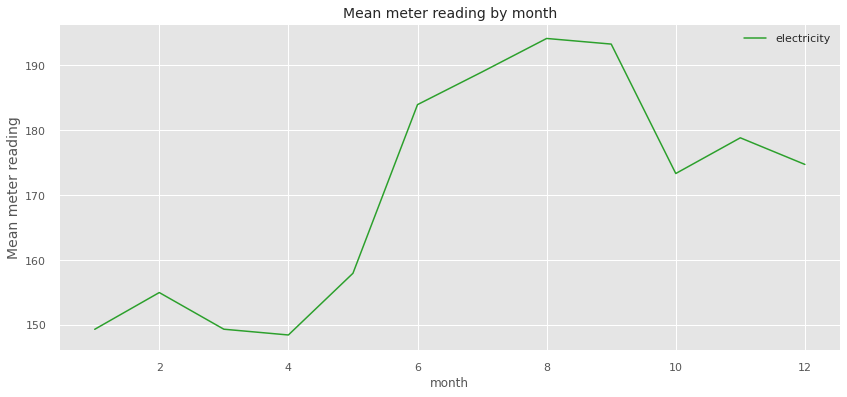

In [141]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))

subset = train[train['meter'] == 0]
subset.groupby('month')['meter_reading'].mean().plot(color='#2ca02c');
axes.set_title('Mean meter reading by month', fontsize=14);
axes.set_ylabel('Mean meter reading', fontsize=14);

plt.legend(['electricity'])

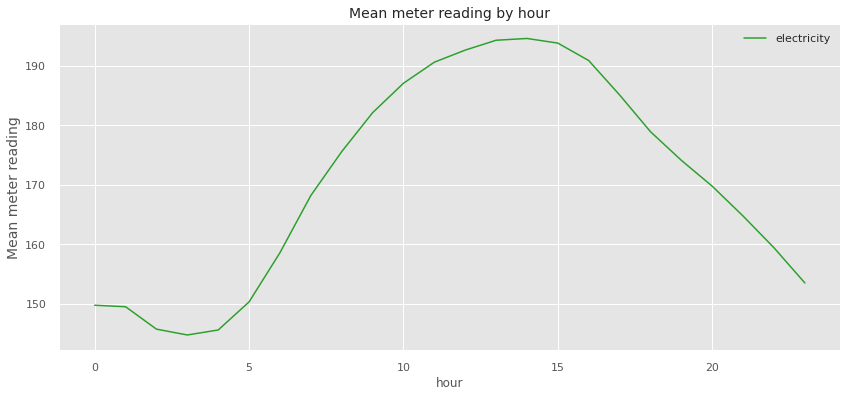

In [142]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))

subset = train[train['meter'] == 0]
subset.groupby('hour')['meter_reading'].mean().plot(color='#2ca02c');
axes.set_title('Mean meter reading by hour', fontsize=14);
axes.set_ylabel('Mean meter reading', fontsize=14);

plt.legend(['electricity'])


**Eau chilled**

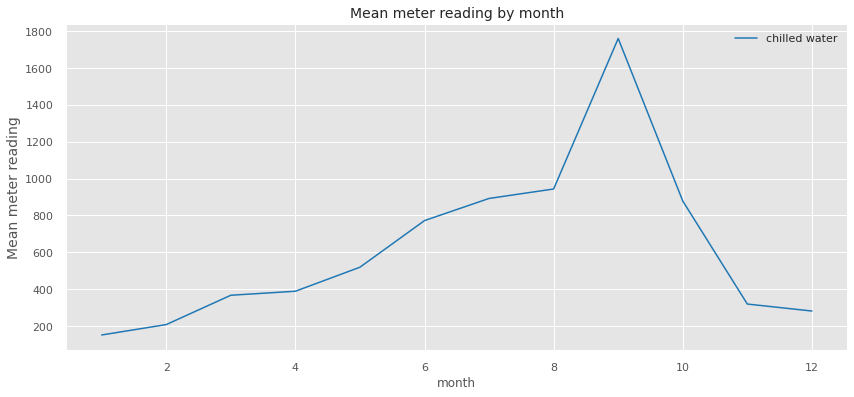

In [143]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))

subset = train[train['meter'] == 1]
subset.groupby('month')['meter_reading'].mean().plot(color='#1f77b4');
axes.set_title('Mean meter reading by month', fontsize=14);
axes.set_ylabel('Mean meter reading', fontsize=14);
plt.legend(['chilled water'])

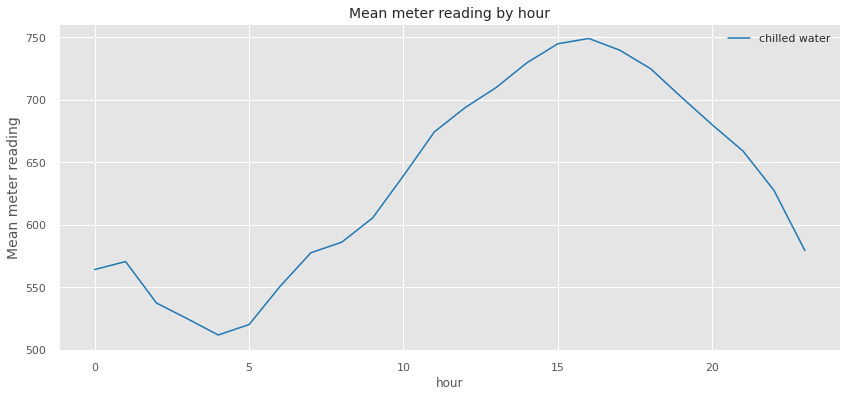

In [144]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))

subset = train[train['meter'] == 1]
subset.groupby('hour')['meter_reading'].mean().plot(color='#1f77b4');
axes.set_title('Mean meter reading by hour', fontsize=14);
axes.set_ylabel('Mean meter reading', fontsize=14);
plt.legend(['chilled water'])

**steam_meter**

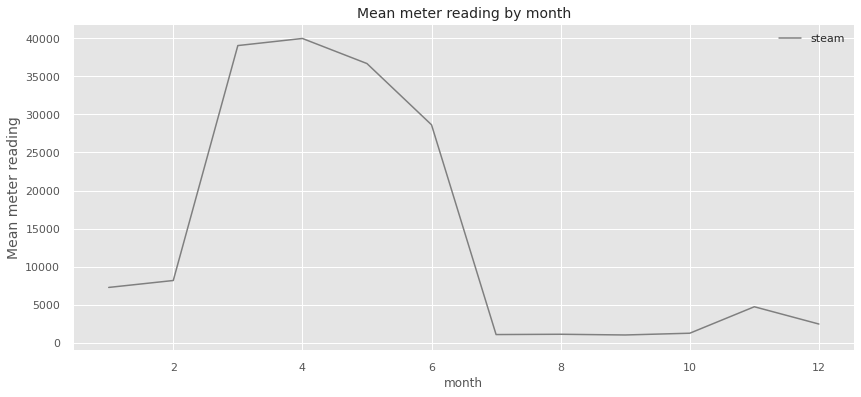

In [145]:

fig, axes = plt.subplots(1,1,figsize=(14, 6))

subset = train[train['meter'] == 2]
subset.groupby('month')['meter_reading'].mean().plot(color='#7f7f7f');
axes.set_title('Mean meter reading by month', fontsize=14);
axes.set_ylabel('Mean meter reading', fontsize=14);
plt.legend(['steam'])

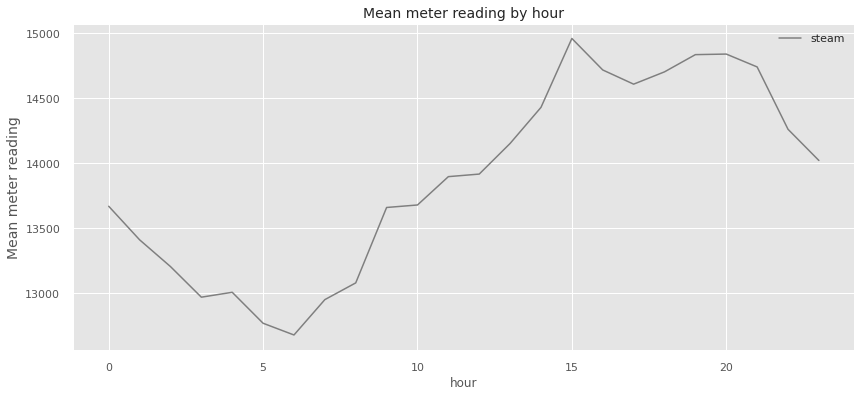

In [146]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))

subset = train[train['meter'] == 2]
subset.groupby('hour')['meter_reading'].mean().plot(color='#7f7f7f');
axes.set_title('Mean meter reading by hour', fontsize=14);
axes.set_ylabel('Mean meter reading', fontsize=14);
plt.legend(['steam'])


**Hot water**

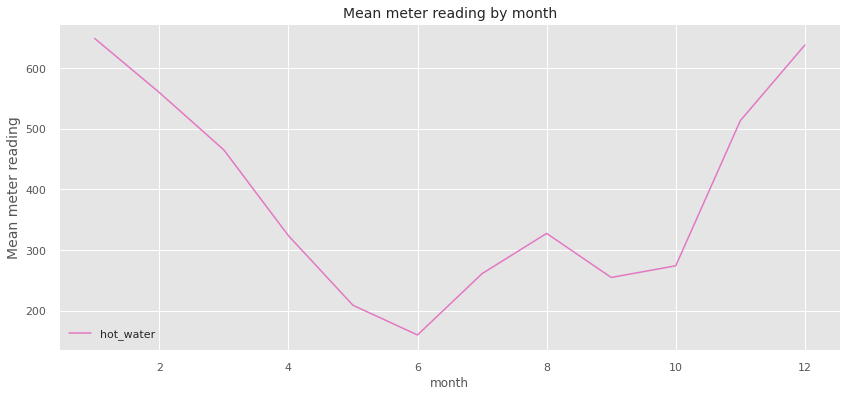

In [147]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))

subset = train[train['meter'] == 3]
subset.groupby('month')['meter_reading'].mean().plot(color= '#e377c2');
axes.set_title('Mean meter reading by month', fontsize=14);
axes.set_ylabel('Mean meter reading', fontsize=14);
plt.legend(['hot_water'])

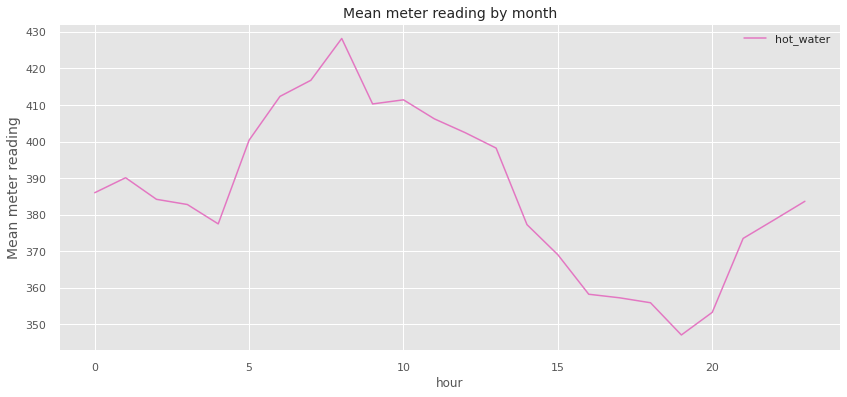

In [150]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))

subset = train[train['meter'] == 3]
subset.groupby('hour')['meter_reading'].mean().plot(color= '#e377c2');
axes.set_title('Mean meter reading by month', fontsize=14);
axes.set_ylabel('Mean meter reading', fontsize=14);
plt.legend(['hot_water'])


outliers: Valeurs abérantes

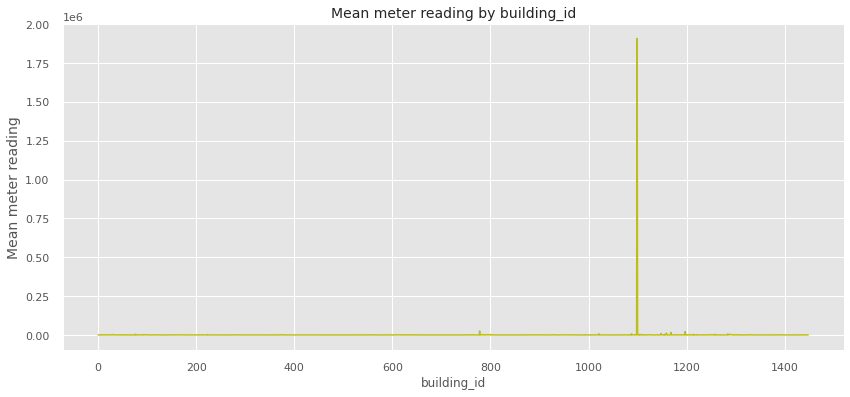

In [151]:

fig, axes = plt.subplots(1,1,figsize=(14, 6))
train.groupby('building_id')['meter_reading'].mean().plot(color='#bcbd22');
axes.set_title('Mean meter reading by building_id', fontsize=14);
axes.set_ylabel('Mean meter reading', fontsize=14);

Dans le schéma on voit qu'une valeur à une valeur importante par rapport aux autres, on peut la considérer comme abérante.

In [152]:
train[train['building_id'] == 1099]['meter_reading'].describe()

count      17566.000
mean     1907325.625
std      4834749.500
min          144.000
25%          520.391
50%          985.697
75%         7008.000
max     21904700.000
Name: meter_reading, dtype: float64

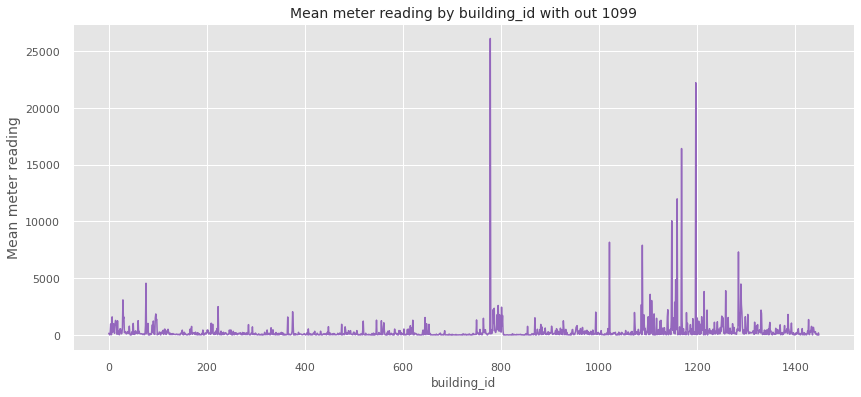

In [153]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))
train[train['building_id'] != 1099].groupby('building_id')['meter_reading'].mean().plot(color='#9467bd');
axes.set_title('Mean meter reading by building_id with out 1099', fontsize=14);
axes.set_ylabel('Mean meter reading', fontsize=14);

## **Weather data**

In [154]:
def plot_dist_col(column):
    '''plot dist curves for train and test weather data for the given column name'''
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.distplot(weather[column].dropna(), color='green', ax=ax).set_title(column, fontsize=16)

    plt.xlabel(column, fontsize=15)
    plt.legend(['train'])
    plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



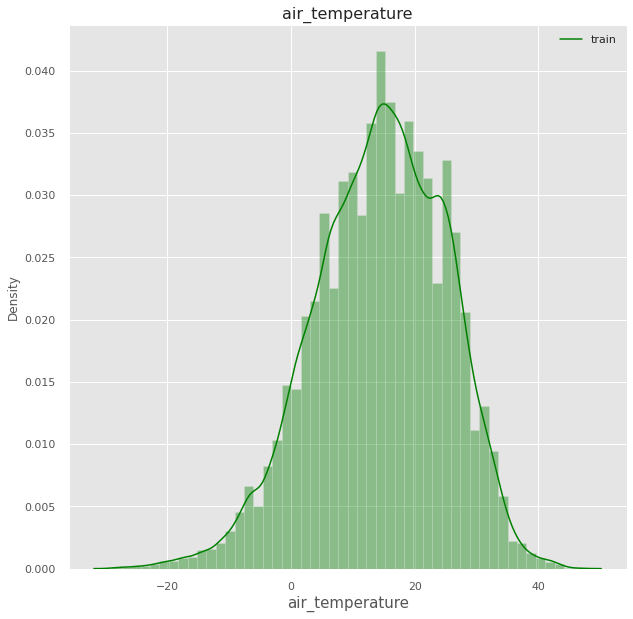

In [155]:
plot_dist_col('air_temperature')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



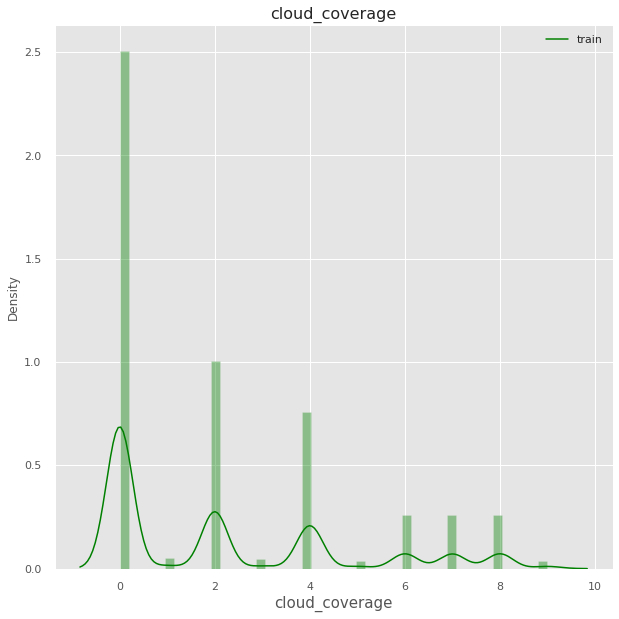

In [156]:
plot_dist_col('cloud_coverage')


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



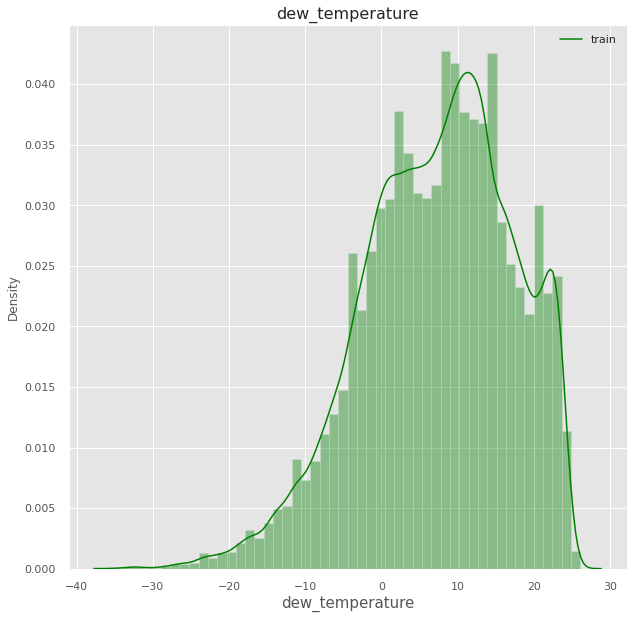

In [157]:
plot_dist_col('dew_temperature')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



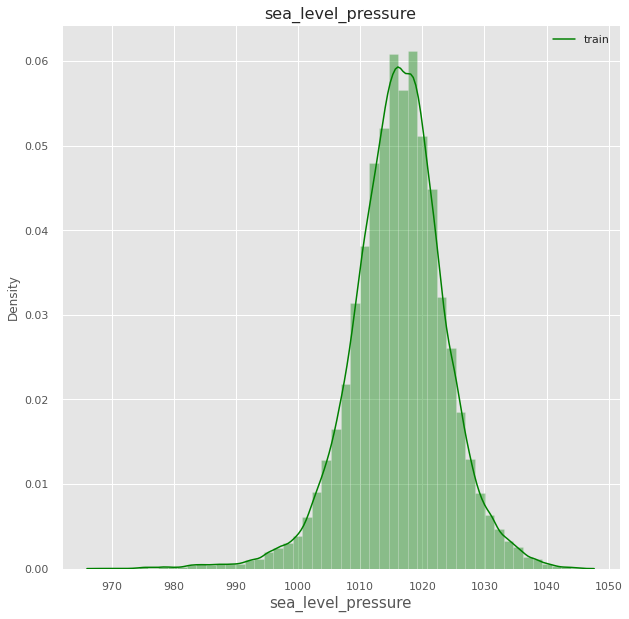

In [158]:
plot_dist_col('sea_level_pressure')


**Meter Reading among Site ID**

In [165]:
# group train dataset per building and meter category
trainble_df= (train.groupby(["building_id", "meter"]).
                     meter_reading.mean().
                     reset_index())


In [166]:
print(trainble_df)

      building_id  meter  meter_reading
0               0      0        146.455
1               1      0         74.865
2               2      0         14.551
3               3      0        235.550
4               4      0        976.557
...           ...    ...            ...
2375         1444      0          7.482
2376         1445      0          4.733
2377         1446      0          3.592
2378         1447      0        187.118
2379         1448      0          3.339

[2380 rows x 3 columns]


In [160]:
trainble_df = (trainble_df.merge(building, 
                                  on='building_id', 
                                  how='left'))
trainble_df['log_meter_reading'] = np.log1p(trainble_df['meter_reading'])

In [161]:
sns.set(style="whitegrid")

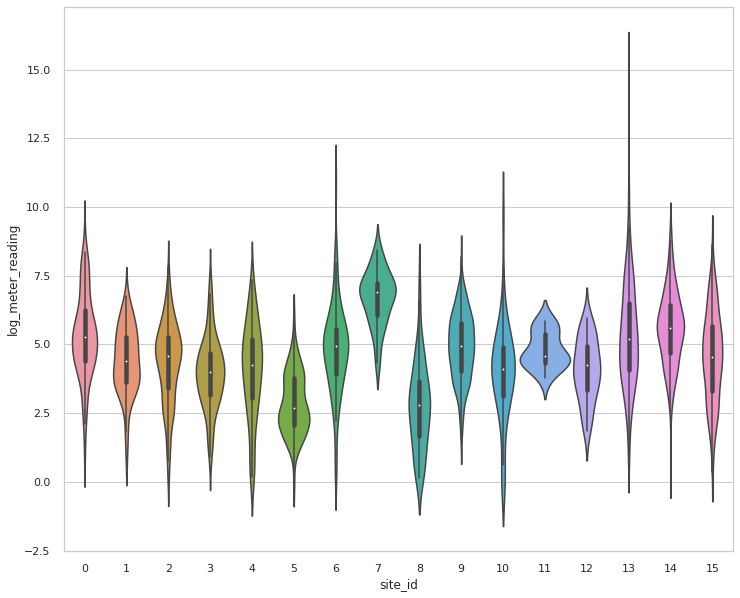

In [162]:
ax = sns.violinplot(x='site_id', y='log_meter_reading',gridsize=200, width=1.2,scale='area',data=trainble_df)


Site ids 0, 1, 2, 3, 4, 5, 8, 9, 14 and 15 ont des distributions similaires de meter reading.

Site ids 6 and 10 meter_reading partagent presque la même distribution et les mêmes statistiques.

Site id 13 a la valeur plus large meter reading et la plus large distribution.

Site id 11 a la valeur la plus étroite ou pétite du meter reading centrée autour de 5.


**meter reading vs floor count**

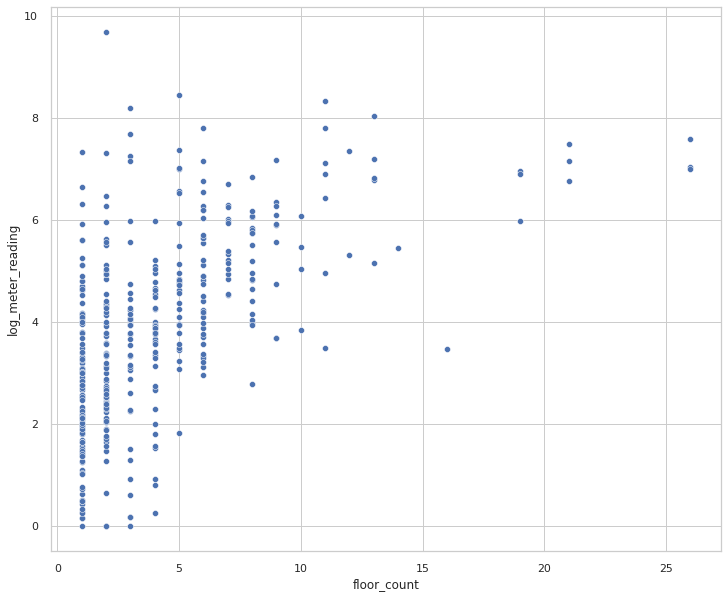

In [163]:
ax = sns.scatterplot(x="floor_count", y="log_meter_reading",
                     data=trainble_df)